### The basic setup

In [1]:
import os
import tempfile
import zipfile
from typing import Union

import census
import dotenv
import geopandas as gpd
import pandas as pd
import requests
import us

dotenv.load_dotenv()

%matplotlib inline

In [2]:
# Create a handler
c = census.Census(os.environ['CENSUS_API_KEY'])

### Pulling data

In this section, we assume that you know the FIPS codes you're looking to exploit. In the following, `us.states.LA.fips` gives us Louisiana's code and `071` is the code for Orleans Parish (the leading `0` is, indeed, important).

In [3]:
# Get total population for all states
data = c.acs5.state(['NAME', 'B01001_001E'], '*')

In [4]:
# Transform into a data frame
variables = ['NAME', 'B01001_001E']
data = c.acs5.state(variables, '*')
df = pd.DataFrame.from_records(data)

# Note that the API returns integers as strings
# This is because sometimes it has things like '250000+' at capped variables
# You can try to convert the type, but be wary of these caps and the
# actual strings that appear.
df['B01001_001E'] = df.B01001_001E.astype(int)
df.head()

,NAME,B01001_001E,state
0,Puerto Rico,3468963,72
1,Alabama,4850771,01
2,Alaska,738565,02
3,Arizona,6809946,04
4,Arkansas,2977944,05


In [5]:
# Same data, but for all tracts in New Orleans
data = c.acs5.state_county_tract(
    variables,
    us.states.LA.fips,  # The US package can be convient to find some basic FIPS codes of states
    '071',  # Search online for "Orleans Parish FIPS code"
    '*'  # Data for *all* tracts in this county
)
df = pd.DataFrame.from_records(data)
df['B01001_001E'] = df.B01001_001E.astype(int)
df.head()

,NAME,B01001_001E,state,county,tract
0,"Census Tract 145, Orleans Parish, Louisiana",2102,22,071,014500
1,"Census Tract 9800, Orleans Parish, Louisiana",10,22,071,980000
2,"Census Tract 17.49, Orleans Parish, Louisiana",3106,22,071,001749
3,"Census Tract 71.01, Orleans Parish, Louisiana",2533,22,071,007101
4,"Census Tract 34, Orleans Parish, Louisiana",1394,22,071,003400


In [6]:
# Some data you may be interested in:
variables = [
    'NAME',         # Name of geography
    'B01001_001E',  # Total population
    'B19013_001E',  # Household median income
]

### Pulling shapefiles

In [7]:
## Grab shapefiles for tracts
def get_shapefile(state_fips: str,
                  filename: str,
                  level: str = 'TRACT',
                  year: Union[str, int] = 2018):
    """
    Get a shapefile from the Census's archive and place it in `filename`.
    
    Args:
        state_fips: The FIPS code of the state to pull the shapefiles for
        filename: The filename to save the shapefile to
        level: What level to pull. Tested on:
            * TRACT
            * COUNTY
            * BG (Block Group)
        year: The year that we will pull shapefiles from
    """
    url = 'https://www2.census.gov/geo/tiger/TIGER{year}/{level}/tl_{year}_{fips}_{lower_level}.zip'.format(
        level=level.upper(),
        lower_level=level.lower(),
        year=year,
        fips=state_fips
    )
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    with open(filename, 'wb') as f:
        for block in resp.iter_content(1024):
            f.write(block)

def open_zipped_shapefile(zipped_shapefile: str) -> gpd.GeoDataFrame:
    """
    Load a shapefile that is zipped into a GeoDataFrame.
    
    Args:
        zipped_shapefile: The location of the shapefile to open
    
    Returns:
        The GeoDataFrame representing this shapefile
    """
    with tempfile.TemporaryDirectory() as tmpdir:
        with zipfile.ZipFile(zipped_shapefile, 'r') as zipref:
            zipref.extractall(tmpdir)
        return gpd.read_file(tmpdir)

In [8]:
get_shapefile(us.states.RI.fips, 'ri_tracts.zip')
tract_df = open_zipped_shapefile('ri_tracts.zip')

In [9]:
# Labeled columns include STATEFP and COUNTYFP for state and county FIPS codes.
tract_df.COUNTYFP.value_counts()

007    141
003     39
009     30
005     23
001     11
Name: COUNTYFP, dtype: int64

### Using shapefiles to enumerate FIPS codes and plotting data

In [10]:
# Get the collection of county FIPS from the tract shapefile
state_county_fips = tract_df[['STATEFP', 'COUNTYFP']].drop_duplicates().values

# Pull all the data from 
data = []
for state_fips, county_fips in state_county_fips:
    pulled = c.acs5.state_county_tract(variables, state_fips, county_fips, '*')
    data.extend(pulled)
    

In [11]:
data_df = pd.DataFrame.from_records(data)
for col in data_df.columns:
    # Convert the data columns to floats
    if col.startswith('B'):
        data_df[col] = data_df[col].astype(float)

# Concatenate the state, county, and tract FIPS to create the full GEOID
# so we can join against the shapefile
data_df['geoid'] = data_df.state + data_df.county + data_df.tract

In [12]:
data_df.head()

,NAME,B01001_001E,B19013_001E,state,county,tract,geoid
0,"Census Tract 417.02, Newport County, Rhode Island",4730.0,89375.0,44,005,041702,44005041702
1,"Census Tract 417.01, Newport County, Rhode Island",3413.0,73958.0,44,005,041701,44005041701
2,"Census Tract 9900, Newport County, Rhode Island",0.0,-666666666.0,44,005,990000,44005990000
3,"Census Tract 413, Newport County, Rhode Island",5505.0,105201.0,44,005,041300,44005041300
4,"Census Tract 416.01, Newport County, Rhode Island",3309.0,54115.0,44,005,041601,44005041601


In [13]:
# Merge the shapefiles and the data
all_data = tract_df.merge(data_df, left_on='GEOID', right_on='geoid')

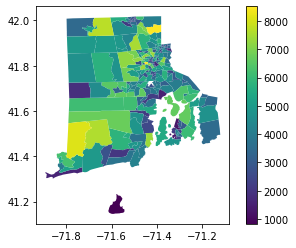

In [14]:
# Plot the population!
# Note that there are tracts that have 0 population (they're water). Exclude them.
all_data[all_data.B01001_001E > 0].plot('B01001_001E', legend=True)